In [1]:
import sys, os
from pathlib import Path
from addict import Dict as Adict
import pandas as pd

In [2]:
sys.path.insert(0, '/home/rzhu/Desktop/projects/kinase_analysis/src/')

from MSMAnalysis import *
import mdtraj as md
from funcs_featurise import *
from funcs_db_assign import *
from funcs_indices import *
from funcs_plotting import *
from funcs_sample import *

In [3]:
protein = 'abl'
job_name = 'n_clusters'

base_path = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/')
data_path = base_path/f'data/{protein}/msm/{job_name}'
summary_f = data_path/f'{job_name}.h5'
hps = pd.read_hdf(summary_f, key='hps')
raw = pd.read_hdf(summary_f, key='result_raw')

summary = raw.groupby('hp_id')[['t2', 'gap_2', 't3', 'gap_3']].agg(['mean', 'std'])
summary

t2                   gap_2                       t3  \
               mean           std      mean       std           mean   
hp_id                                                                  
0      1.897906e+06  2.256119e+06  7.204462  9.030466  325705.297247   
1      1.595177e+06  1.815086e+06  4.080848  5.590142  432235.379029   
2      2.136673e+06  3.122491e+06  4.077578  6.400808  535565.850037   
3      2.592150e+06  3.314022e+06  4.691758  5.925844  548228.747968   
4      2.344402e+06  3.034237e+06  4.193718  5.694533  575423.340252   
5      2.326571e+06  3.044765e+06  4.213856  5.890504  578997.424399   

                         gap_3            
                 std      mean       std  
hp_id                                     
0      387121.561458  2.595602  1.789663  
1      290889.808255  2.997026  4.150378  
2      326925.648340  3.210125  3.339652  
3      343147.326564  2.609170  1.852093  
4      413670.471434  2.750514  2.390593  
5      418920.923081  2.803241  2.576391

In [4]:
hp_id = 2
hp_dict = Adict(hps[hps.hp_id == hp_id].to_dict('records')[0])

# Set additional parameters for the MSM study 
hp_dict['markov__mode'] = 'ml'
hp_dict['count__mode'] = 'sliding'

In [5]:
all_features = ['dbdist', 'dbdihed', 'aloop', 'achelix']

MA = MSMAnalysis(protein, trajlen_cutoff=1000)
MA.load_ftrajs(features=all_features, arc_dir=base_path/'data'/f'{protein}'/'ftrajs')

Loading feature:  dbdist


100%|██████████| 749/749 [00:00<00:00, 8444.08it/s]


Loading feature:  dbdihed


100%|██████████| 749/749 [00:00<00:00, 2483.98it/s]


Loading feature:  aloop


100%|██████████| 749/749 [00:02<00:00, 264.35it/s]


Loading feature:  achelix


100%|██████████| 749/749 [00:00<00:00, 8534.71it/s]

Features loaded: {'dbdihed', 'achelix', 'aloop', 'dbdist'}


Load in crystal structures for projections.

In [6]:
crystal_files = natsorted([str(f) for f in Path(f"/arc/human_{protein}/").glob("kinoml*.pdb")])

frames = [] 
for crystal in crystal_files:
    sample_frame = md.load(crystal)
    sample_frame = sample_frame.atom_slice(sample_frame.top.select('mass>1.1'))
    frames.append(sample_frame)
crystals = md.join(frames)
crystals = crystals.superpose(crystals, 0)

featurisers = [dbdist_featuriser, dbdihed_featuriser, aloop_featuriser, achelix_featuriser]
c_ftrajs_dict = {f.__name__.split('_')[0]:[f(traj=crystals, protein=protein)] for f in featurisers}
MA.load_data(data_key='crystal', ftraj_dict=c_ftrajs_dict)
c_ftrajs, _ = prepare_ftrajs(MA.data['crystal'], stride=1, len_cutoff=1)

KeyboardInterrupt: 

Create a new study if models have not been saved to disk.

In [6]:
study = MA.create_study(study_name=f'{job_name}_hp{hp_id}_validate', 
                        hp_dict=hp_dict, 
                        features=all_features,
                        stride=1,
                        create_new=True,
                        wk_dir=base_path/f'data/{protein}/msm/validation/{job_name}_hp{hp_id}_validate')
study.set_pcca(6)
study.estimate_MSM()
study.save_models()

Preparing feature trajectories...


100%|██████████| 749/749 [00:03<00:00, 220.47it/s]
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


Parameter hp_id not allowed, ignore. Check the allowed parameters
Parameter trajlen__cutoff not allowed, ignore. Check the allowed parameters
Parameter n__boot not allowed, ignore. Check the allowed parameters
Parameter seed not allowed, ignore. Check the allowed parameters
Number of metastable states not specified. Defaulting to 5. Run set_pcca() to set the number of metastable states
Set number of metastable states to  6


100%|██████████| 426/426 [00:08<00:00, 50.01it/s]                        
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 1000/1000 [00:00<00:00, 1760.12it/s]


Found disconnected states: [  3   6  80  91 140 157 162 204 233 259 267 275 361 406 408 412 419 431
 450 492 521 529 561 591 627 628 704 747 762 786 797 799 816 885 898 902
 950 959 974 986]
MSM estimation complete
28-06-24 16:56:10 pyemma._base.serialization.h5file INFO     overwriting model "default" in file /home/rzhu/Desktop/projects/kinase_analysis/data/abl/msm/validation/n_clusters_hp2_validate/models/tica_model
28-06-24 16:56:10 pyemma._base.serialization.h5file INFO     overwriting model "default" in file /home/rzhu/Desktop/projects/kinase_analysis/data/abl/msm/validation/n_clusters_hp2_validate/models/kmeans_model


Otherwise load models from a working directory.

In [6]:
study = MA.create_study(study_name=None,
                        hp_dict=hp_dict,    # hp_dict is ignored 
                        features=all_features,
                        create_new=False,
                        wk_dir=base_path/f'data/{protein}/msm/validation/{job_name}_hp{hp_id}_effective_count')

Preparing feature trajectories...


100%|██████████| 749/749 [00:03<00:00, 219.07it/s]
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


Restoring study: n_clusters_hp2_effective_count
Restoring TICA model
Restoring Kmeans model


/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


Restoring transition count model
Restoring Bayesian MSM model
Models restore complete.


### Where do the cluster centroids land on the free energy surface?

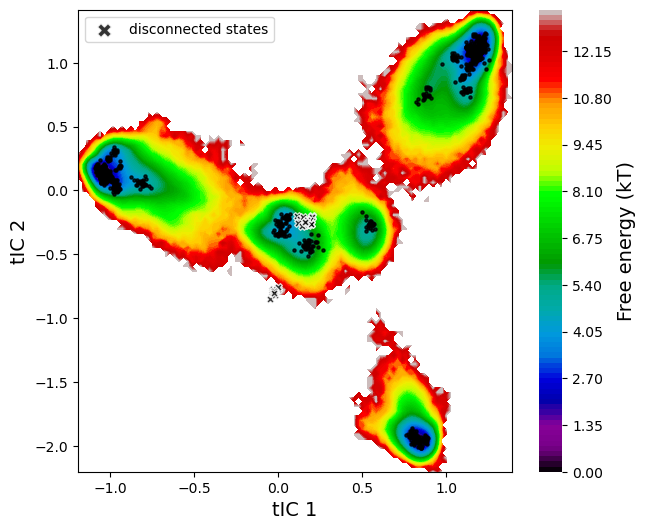

In [9]:
plot_fe(traj_all=study.ttraj_cat,
        traj_weights = np.concatenate(study.traj_weights, axis=0),
        c_centers=study.kmeans_centers[study.connected_states, :],
        c_centers_s=20,
        d_centers=study.kmeans_centers[study.disconnected_states, :],
        d_centers_s=30,
        savedir=study.fig_dir/'free_energy.png'
        )

### Timescales

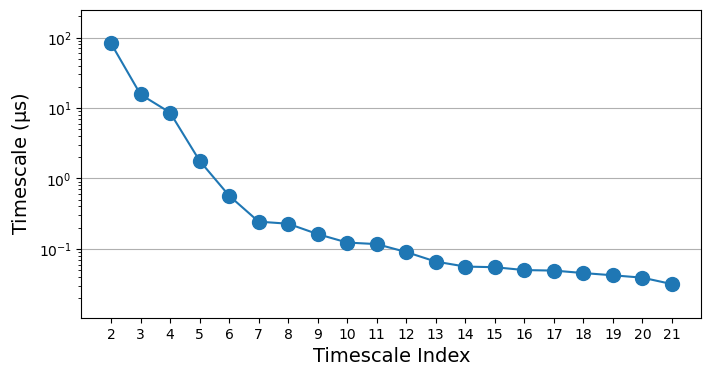

In [11]:
plot_ts(
        #timescales=study.baymsm_mod.timescales()[1], 
        timescales=study.msm_mod.timescales(),
        n_ts = 20, 
        markov_lag = study._markov__lag, 
        scaling = 0.00005, 
        savedir = study.fig_dir/'timescales.png', 
        unit="$\mathrm{\mu s}$")

### Coarse-grain with PCCA

/home/rzhu/Desktop/projects/kinase_analysis/src/funcs_plotting.py:86: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(c_centers[state_assignment == i, dim_1], c_centers[state_assignment == i, dim_2],
/home/rzhu/Desktop/projects/kinase_analysis/src/funcs_plotting.py:86: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(c_centers[state_assignment == i, dim_1], c_centers[state_assignment == i, dim_2],
/home/rzhu

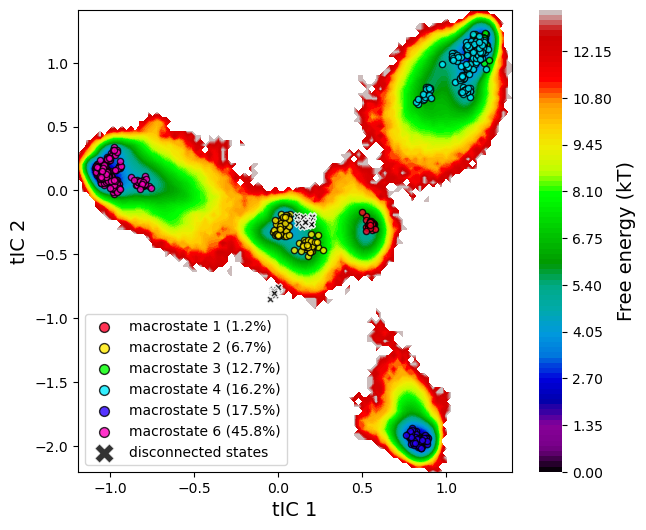

In [13]:
plot_fe(traj_all=study.ttraj_cat,
        traj_weights = np.concatenate(study.traj_weights, axis=0),
        c_centers=study.kmeans_centers[study.connected_states, :],
        c_centers_s=80,
        state_assignment=study.pcca_mod.assignments,
        state_population=study.pcca_mod.coarse_grained_stationary_probability,
        linewidth=1,
        d_centers=study.kmeans_centers[study.disconnected_states, :],
        d_centers_s=30,
        d_centers_marker='X',
        legend_marker_sizes=[200, 200, 200, 200, 200, 200, 200],
        savedir = study.fig_dir/'pcca.png' 
        )

### Assign spatial and dihedral cluster to macrostates

In [14]:
dbdist, _ = prepare_ftrajs(MA.select_ftrajs(features=['dbdist']))
dbdist_cat = np.concatenate(dbdist)
dbdihed, _ = prepare_ftrajs(MA.select_ftrajs(features=['dbdihed']), convert_dihed=False)
dbdihed_cat = np.concatenate(dbdihed)

Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 18286.42it/s]


Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 4155.79it/s]


In [15]:
sim_ptraj_cat = np.array([study.micro_to_macro[d] if d in study.connected_states else -1 for d in study.dtraj_cat])

In [16]:
dihed_cluster_labels = ['noise', 'BLAminus', 'BLAplus', 'ABAminus', 'BLBminus', 'BLBplus', 'BLBtrans', 'BABtrans', 'BBAminus']
spatial_cluster_labels = ['DFG-in', 'DFG-inter', 'DFG-out']

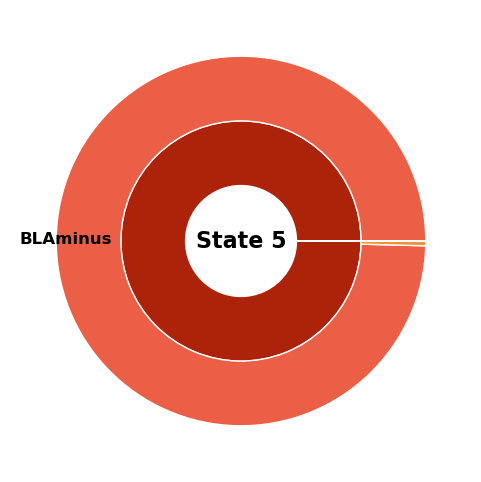

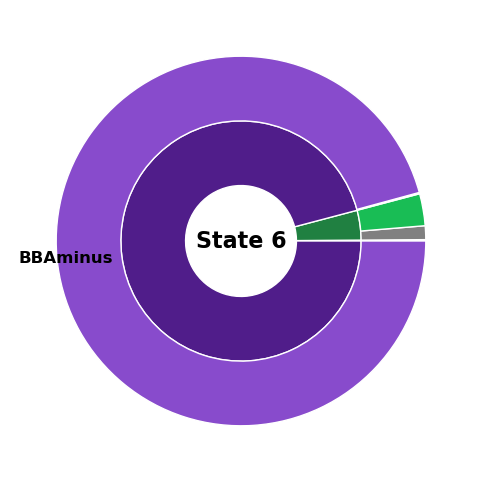

In [18]:
for state_i in range(study._pcca_n):
    frame_indices = np.where(sim_ptraj_cat == state_i)[0]
    dbdist_i, dbdihed_i = dbdist_cat[frame_indices], dbdihed_cat[frame_indices]
    
    spatial_assignments, dihed_assignments = dfg_featuriser(dists=dbdist_i, diheds=dbdihed_i[:,[0,1,2,3,4,5,8]], \
                                                            dist_centroids = np.load(base_path/f'data/{protein}/cluster_centers/dfg_spatial_centroids.npy', allow_pickle=True), 
                                                            dihed_centroids = np.load(base_path/f'data/{protein}/cluster_centers/dfg_dihed_centroids.npy', allow_pickle=True).item(), 
                                                            dihed_cutoff=1.5)
    spatial_counts, dihed_counts = dunbrack_count(spatial_assignments, dihed_assignments)
    plot_dihed_pie(spatial_counts, dihed_counts, radius_size=0.35, show_legend=False, show_clusters=True,
                   title=f'State {state_i+1}', savedir=study.fig_dir/f'state_{state_i+1}_dihed.png')

### Project starting conformations onto tICA space

In [20]:
c_ttraj, c_dtraj, c_connected_d, c_disconnected_d, c_ptraj = study.transform(c_ftrajs)

NameError: name 'c_ftrajs' is not defined

/home/rzhu/Desktop/projects/kinase_analysis/src/funcs_plotting.py:93: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(c_centers[state_assignment == i, dim_1], c_centers[state_assignment == i, dim_2],
/home/rzhu/Desktop/projects/kinase_analysis/src/funcs_plotting.py:93: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(c_centers[state_assignment == i, dim_1], c_centers[state_assignment == i, dim_2],
/home/rzhu

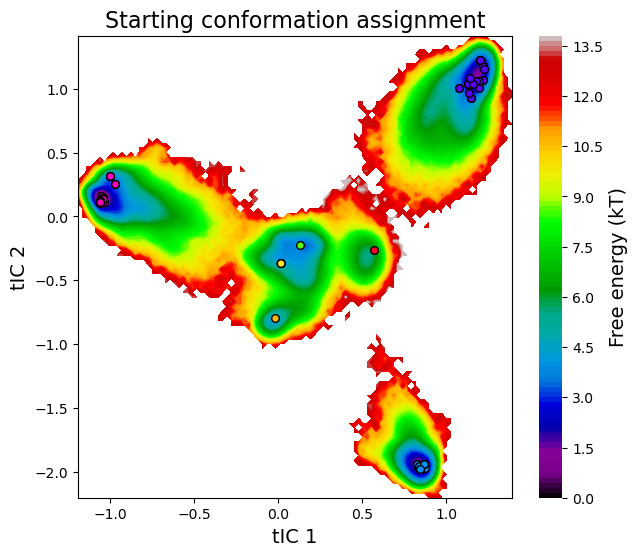

In [23]:
plot_fe(traj_all=study.ttraj_cat,
        traj_weights = np.concatenate(study.traj_weights, axis=0),
        c_centers = study.kmeans_centers[c_connected_d, :],
        c_centers_marker = 'o',
        c_centers_a = 1,
        c_centers_s = 30,
        linewidth=1,
        #d_centers=study.kmeans_centers[c_disconnected_d, :],
        #d_centers_s=100,
        #d_centers_marker='X',
        state_assignment=c_ptraj,
        title='Starting conformation assignment',
        savedir=study.fig_dir/'free_energy_with_initial_states.png')

What are the two crystal structures that lead to disconnected states?

In [19]:
unique, counts = np.unique(c_ptraj, return_counts=True)
d1, d2 = np.where(c_dtraj == c_disconnected_d[0])[0][0], np.where(c_dtraj == c_disconnected_d[1])[0][0]
crystal_files[d1], crystal_files[d2]

NameError: name 'c_ptraj' is not defined

Proportion of starting conformations vs simulation data in each state

In [28]:
all_spatial_assignments, all_dihed_assignments = dfg_featuriser(dists=dbdist_cat, diheds=dbdihed_cat[:,[0,1,2,3,4,5,8]], \
                                                              dist_centroids = np.load(base_path/f'data/{protein}/cluster_centers/dfg_spatial_centroids.npy', allow_pickle=True), 
                                                              dihed_centroids = np.load(base_path/f'data/{protein}/cluster_centers/dfg_dihed_centroids.npy', allow_pickle=True).item(), 
                                                              dihed_cutoff=1.5)
all_spatial_counts, all_dihed_counts = dunbrack_count(all_spatial_assignments, all_dihed_assignments)

In [29]:
c_dbdists = MA.select_ftrajs(features=['dbdist'], data_key='crystal')['dbdist']
c_dbdist_cat = np.concatenate(c_dbdists)
c_dbdiheds = MA.select_ftrajs(features=['dbdihed'], data_key='crystal')['dbdihed']
c_dbdihed_cat = np.concatenate(c_dbdiheds)

In [30]:
crystal_spatial_assignments, crystal_dihed_assignments = dfg_featuriser(dists=c_dbdist_cat, diheds=c_dbdihed_cat[:,[0,1,2,3,4,5,8]], 
                                                                      dist_centroids = np.load(base_path/f'data/{protein}/cluster_centers/dfg_spatial_centroids.npy', allow_pickle=True), 
                                                                      dihed_centroids = np.load(base_path/f'data/{protein}/cluster_centers/dfg_dihed_centroids.npy', allow_pickle=True).item(), 
                                                                      dihed_cutoff=1.5)
crystal_spatial_counts, crystal_dihed_counts = dunbrack_count(all_spatial_assignments, all_dihed_assignments)

In [31]:
sim_diheds = [np.sum([i[0] for i in all_dihed_counts])] + all_dihed_counts[0][1:] + all_dihed_counts[1][1:] + all_dihed_counts[2][1:]
crystal_diheds = [np.sum([i[0] for i in crystal_dihed_counts])] + crystal_dihed_counts[0][1:] + crystal_dihed_counts[1][1:] + crystal_dihed_counts[2][1:]

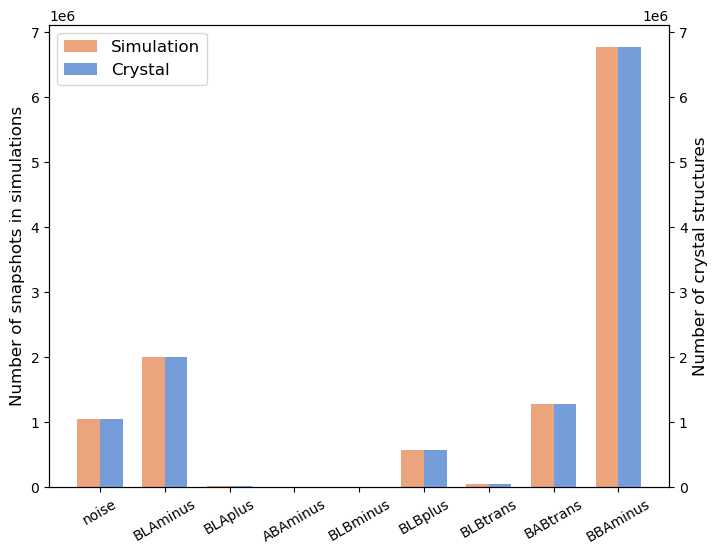

In [32]:
ind = np.arange(9)
width = 0.35

fig, ax1 = plt.subplots(figsize=(8, 6))
bars1 = ax1.bar(ind - width/2, sim_diheds, width, label='Simulation', color=(236/255, 164/255, 124/255))
ax1.set_ylabel('Number of snapshots in simulations', fontsize=12)
#ax1.set_yscale('log')

ax2 = ax1.twinx()
bars2 = ax2.bar(ind + width/2, crystal_diheds, width, label='Crystal', color=(117/255, 157/255, 218/255))
ax2.set_ylabel('Number of crystal structures', fontsize=12)
#ax2.set_yscale('log')

ax1.set_xticks(ind)
ax1.set_xticklabels(dihed_cluster_labels, rotation=30)

bars_1, labels_1 = ax1.get_legend_handles_labels()
bars_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(bars_1 + bars_2, labels_1 + labels_2, loc='upper left', fontsize=12, markerscale=4)

plt.savefig('/home/rzhu/Desktop/projects/kinase_analysis/data/abl/plots/simulation_vs_crystal_count.png',
             transparent=True, bbox_inches='tight', dpi=300)

### Coarse-grained transition matrix and MFPT

In [24]:
mfpt = np.zeros([study.pcca_n, study.pcca_n])
mfpt_std = np.zeros([study.pcca_n, study.pcca_n])

for i in range(study.pcca_n):
    for j in range(study.pcca_n):
        mfpt[i,j] = study.baymsm_mod.gather_stats('mfpt', A=study.pcca_mod.sets[i], B=study.pcca_mod.sets[j]).mean
        mfpt_std[i,j] = study.baymsm_mod.gather_stats('mfpt', A=study.pcca_mod.sets[i], B=study.pcca_mod.sets[j]).std

In [22]:
mfpt = np.zeros([study.pcca_n, study.pcca_n])
for i in range(study.pcca_n):
    for j in range(study.pcca_n):
        mfpt[i,j] = study.msm_mod.mfpt(A=study.pcca_mod.sets[i], B=study.pcca_mod.sets[j])

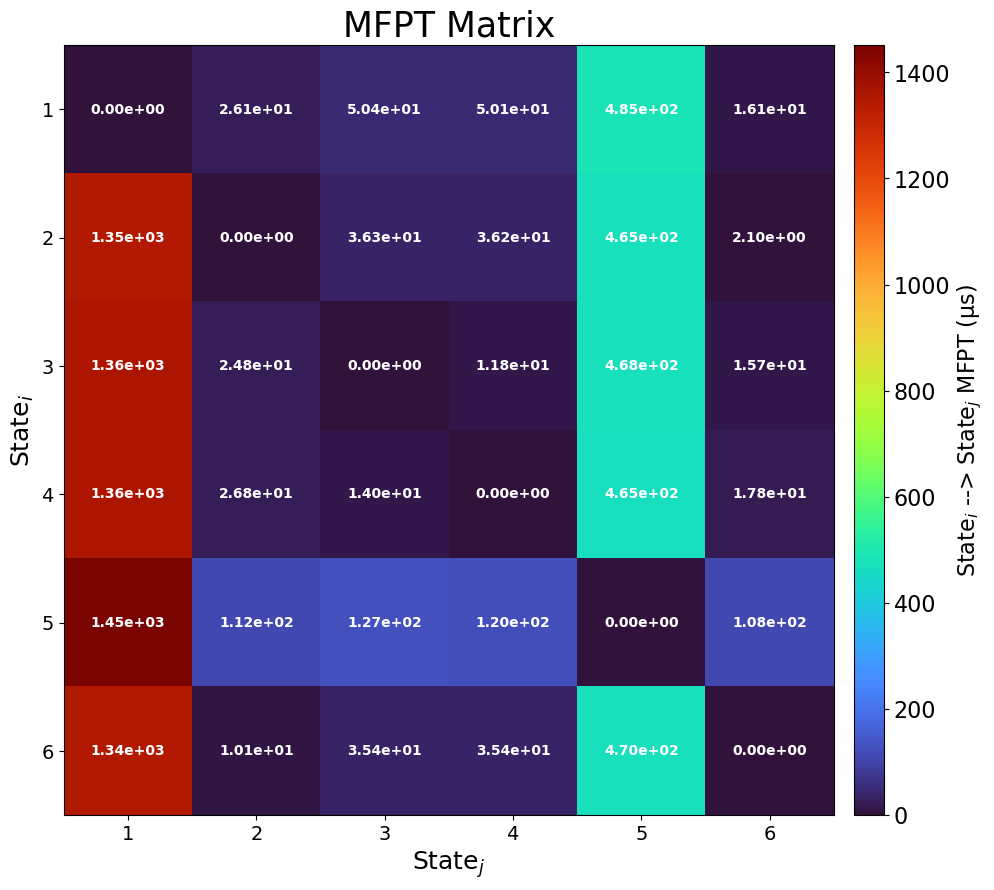

In [24]:
plot_mfpt_matrix(mfpt = mfpt,
                 #mfpt_err = mfpt_std, 
                 savedir = study.fig_dir/'mfpt_matrix.png',
                 scaling=0.00005,
                 unit="$\mathrm{\mu s}$", 
                 text_f =".2e")

/home/rzhu/Desktop/projects/kinase_analysis/src/funcs_plotting.py:158: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(c_centers[pcca_assignment == i, dim_1], c_centers[pcca_assignment == i, dim_2],
/home/rzhu/Desktop/projects/kinase_analysis/src/funcs_plotting.py:158: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(c_centers[pcca_assignment == i, dim_1], c_centers[pcca_assignment == i, dim_2],
/home/rzhu/D

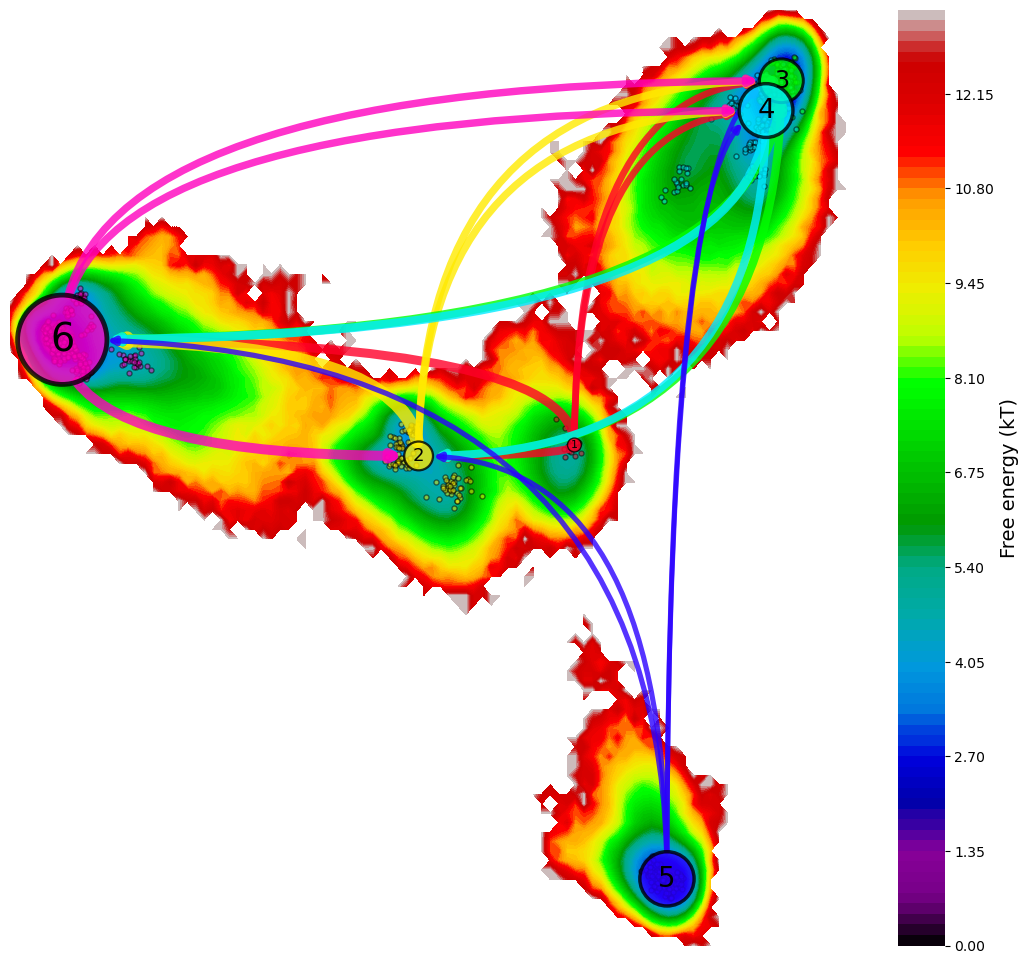

In [25]:
plot_pcca_graph(traj_all = study.ttraj_cat,
                traj_weights = np.concatenate(study.traj_weights, axis=0),
                c_centers = study.kmeans_centers[study.connected_states, :],
                c_centers_a = 0.5,
                c_centers_s = 50,
                matrix = mfpt,
                pcca_assignment = study.pcca_mod.assignments,
                stat_dist = study.msm_mod.stationary_distribution,
                savedir = study.fig_dir/'mfpt_graph.png')

### Eigenvectors

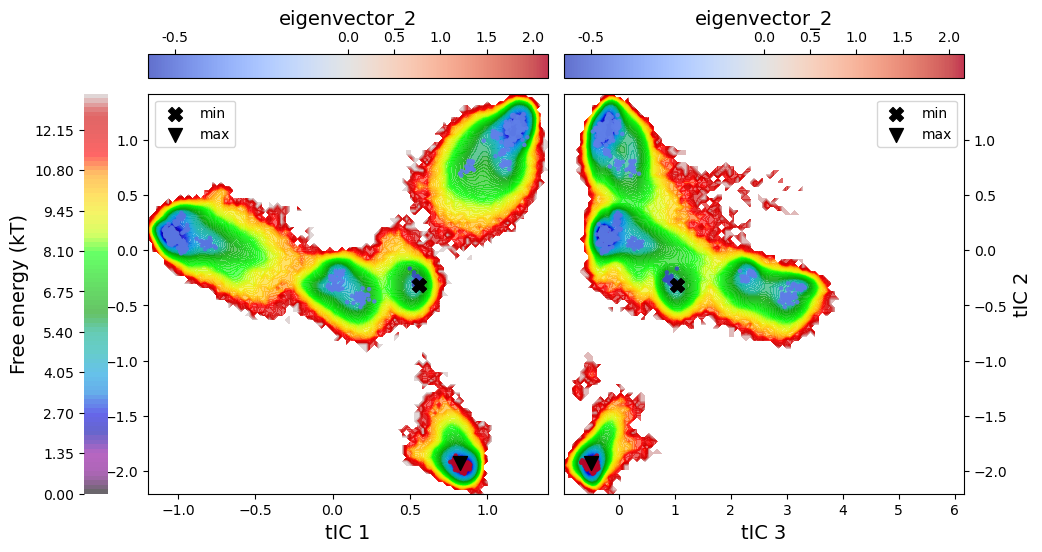

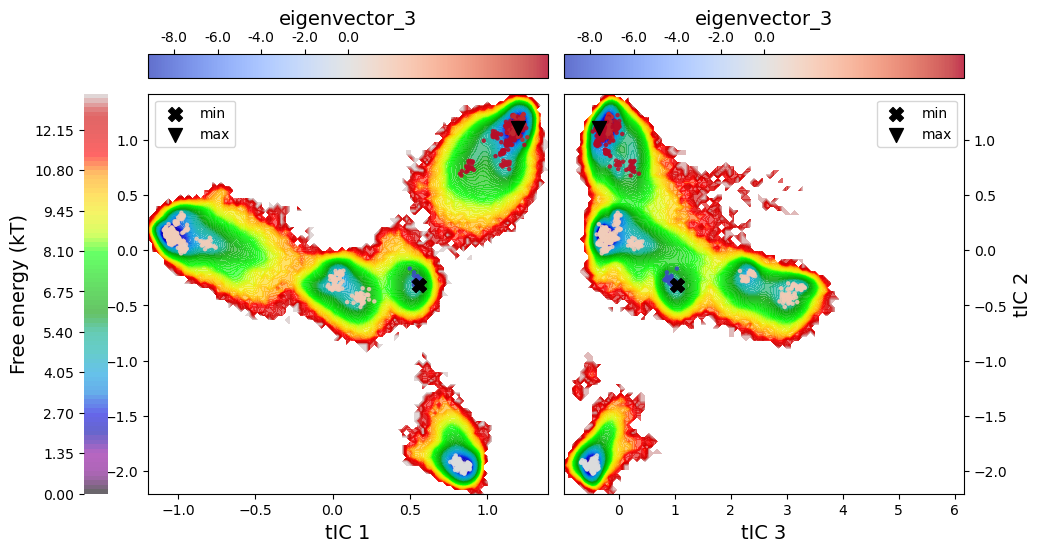

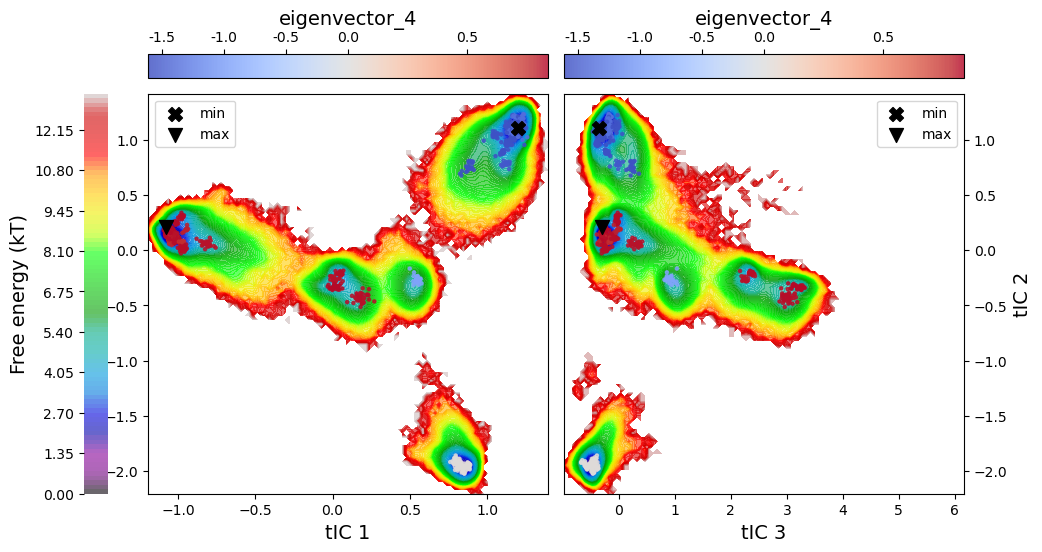

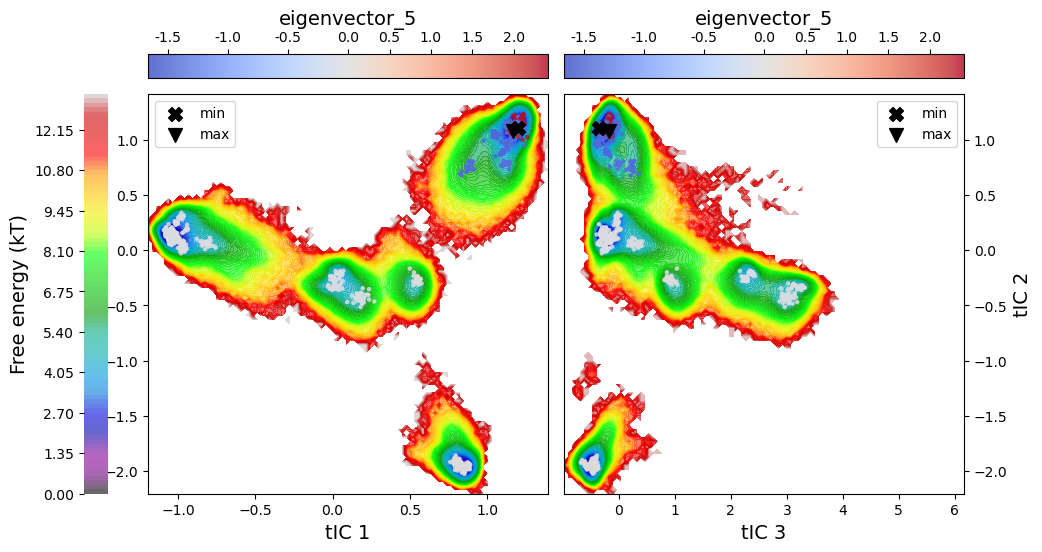

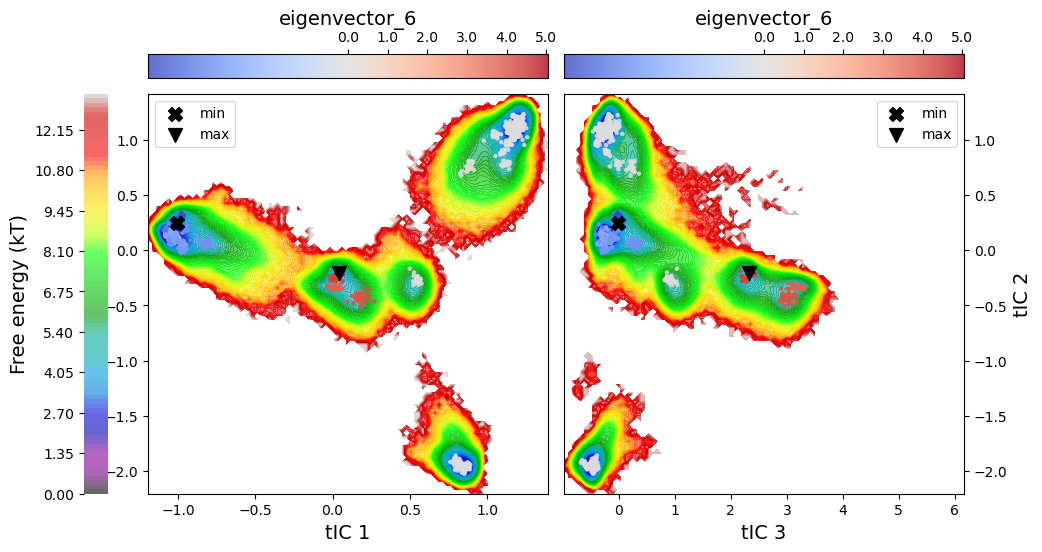

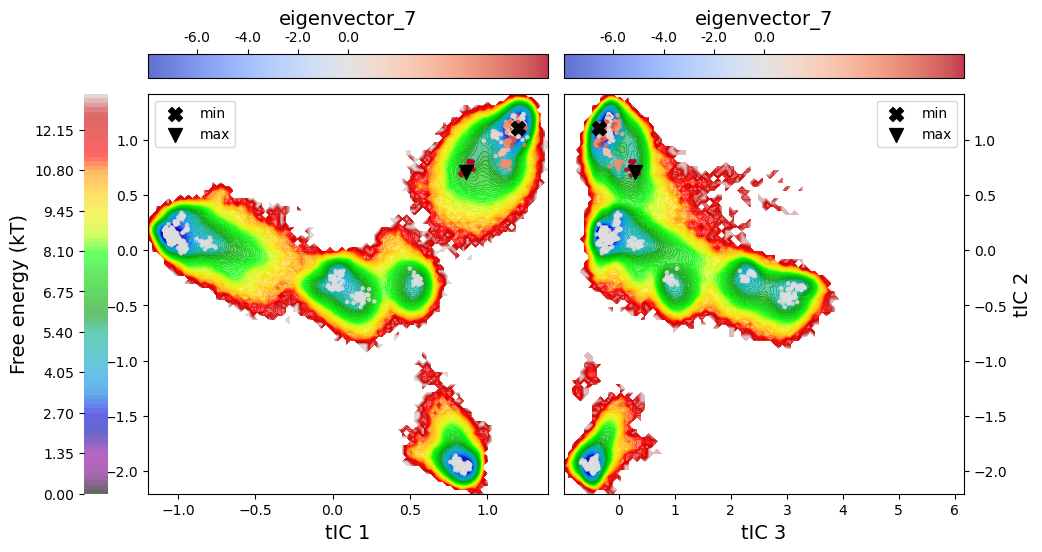

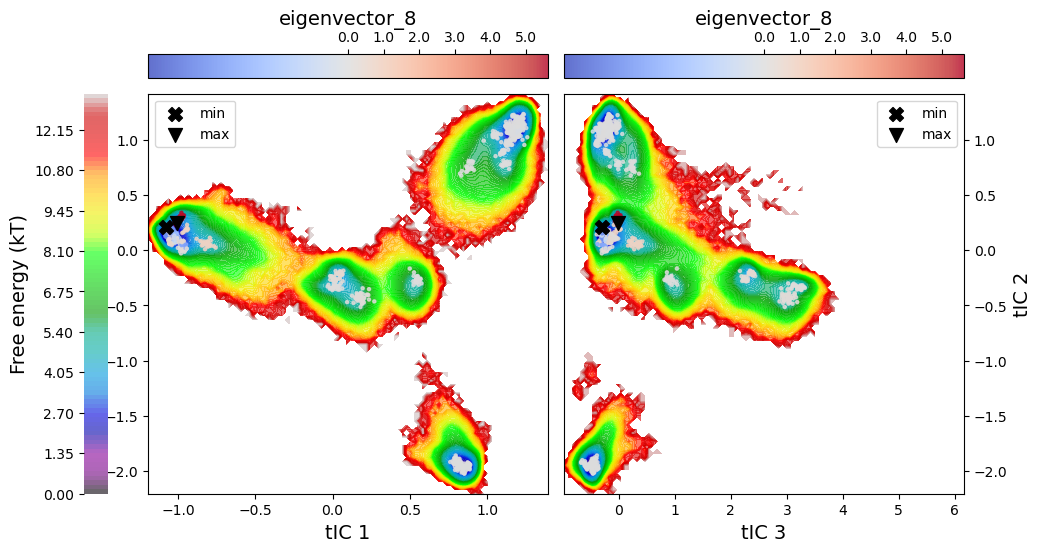

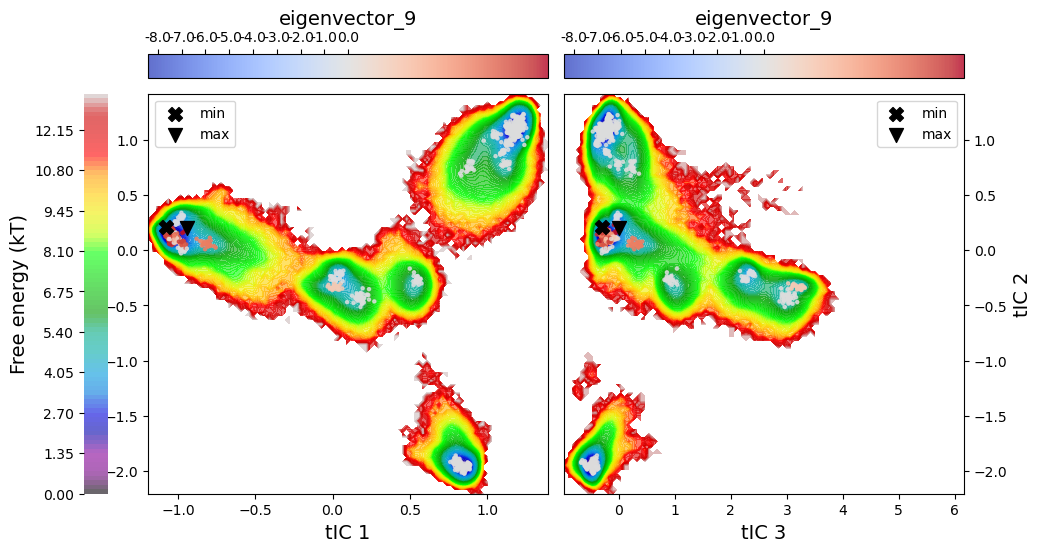

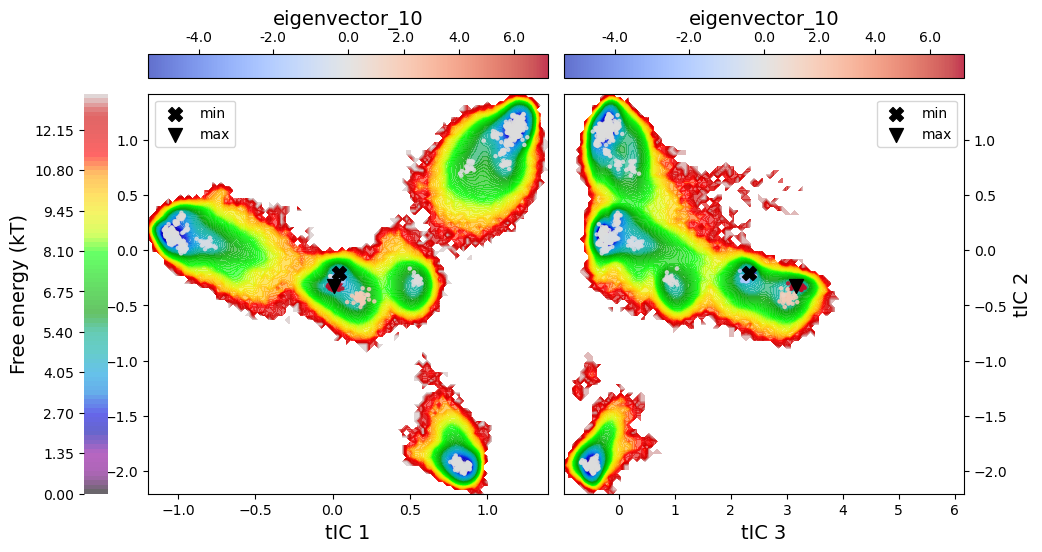

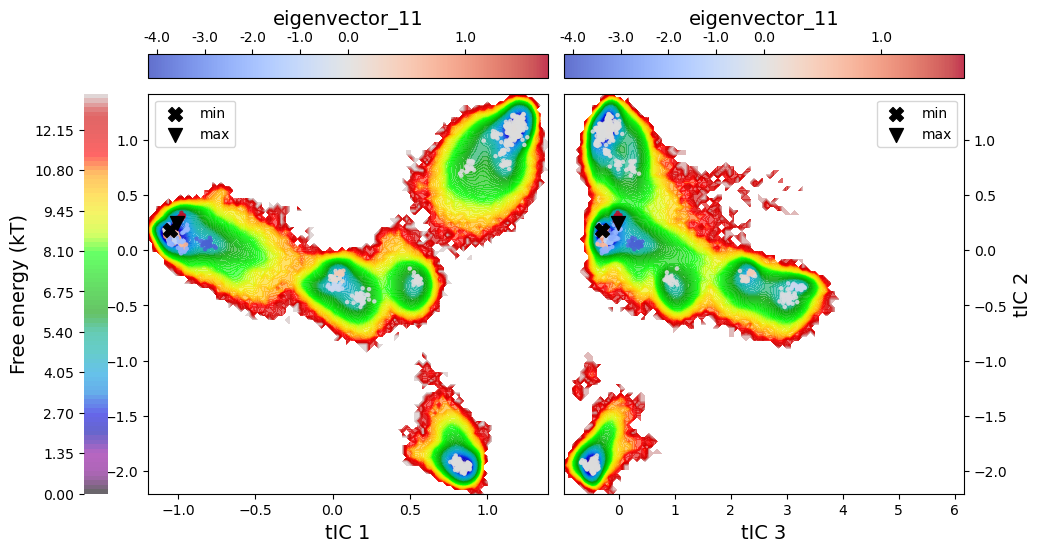

In [26]:
for ev_id in range(10):
        plot_ev(ev = study.msm_mod.eigenvectors_right()[:,ev_id+1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ],
                c_centers = study.kmeans_centers[study.connected_states,:],
                traj_all = study.ttraj_cat,
                traj_weights = np.concatenate(study.traj_weights,axis=0),
                title = f'eigenvector_{ev_id+2}',
                savedir = study.fig_dir/f'eigenvector_{ev_id+2}.png')

### Sample pcca states and save examples

In [8]:
traj_files = natsorted([traj for traj in Path(f'/arc/{protein}_processed').rglob('run*-clone?.h5')])

In [27]:
with open(study.sample_dir/f'samples.txt', 'w') as f:
    f.writelines(f'macrostate,microstate,traj_id,frame_id\n')

for pcca_state in range(study.pcca_n):
    membership_cutoff = 0.8  # Only sample microstates that are highly committed to a macrostate

    memberships = study.pcca_mod.memberships[:,pcca_state]
    states_to_sample = memberships > membership_cutoff

    stationary_distribution = study.msm_mod.stationary_distribution.copy()
    stationary_distribution[~states_to_sample] = 0
    sample_distribution = stationary_distribution / np.sum(stationary_distribution)

    state_samples_count = sample_states_by_distribution(sample_distribution, study.connected_states, 20)
    samples = sample_frames_by_states(state_samples_count, study.dtrajs, mapping=study.mapping)
    print(state_samples_count) # Print what microstates are sampled and how many samples from each 

    with open(study.sample_dir/f'samples.txt', 'a') as f:
        sample_id = 0        
        for state, n_samples in state_samples_count.items():
            for i in range(n_samples):
                f.writelines(f'{pcca_state+1},{state},{samples[sample_id][0]},{samples[sample_id][1]}\n')
                sample_id += 1
    save_samples(samples, traj_files, study.sample_dir/f'MS_{pcca_state+1}.pdb')

{88: 4, 582: 1, 771: 5, 814: 1, 824: 2, 850: 1, 852: 4, 864: 1, 983: 1}
{12: 1, 84: 1, 109: 1, 182: 1, 190: 1, 224: 1, 331: 1, 357: 1, 437: 1, 604: 1, 765: 1, 808: 3, 821: 1, 844: 1, 856: 3, 990: 1}
{21: 1, 115: 2, 149: 1, 194: 1, 195: 1, 212: 1, 289: 1, 478: 1, 556: 1, 577: 1, 655: 1, 667: 2, 745: 1, 849: 1, 888: 1, 933: 1, 935: 1, 988: 1}
{7: 1, 30: 1, 39: 1, 101: 1, 207: 1, 210: 1, 231: 1, 329: 1, 417: 1, 471: 1, 487: 1, 490: 1, 688: 1, 694: 1, 795: 2, 836: 1, 871: 1, 874: 1, 932: 1}
{58: 1, 75: 1, 82: 1, 99: 1, 172: 1, 198: 1, 208: 1, 284: 1, 314: 1, 358: 1, 461: 1, 653: 1, 657: 1, 689: 1, 712: 1, 725: 1, 831: 1, 840: 1, 899: 1, 992: 1}
{14: 1, 15: 1, 31: 1, 166: 1, 173: 1, 180: 1, 260: 1, 273: 1, 306: 1, 356: 1, 414: 1, 447: 1, 491: 1, 508: 1, 581: 1, 638: 1, 659: 1, 663: 1, 801: 1, 919: 1}


### Sample pcca extreme states

In [28]:
traj_files = natsorted([str(f) for f in Path(f"/arc/{protein}_processed/").rglob('run*-clone?.h5')])
with open(study.sample_dir/f'samples_ex.txt', 'w') as f:
    f.writelines(f'macrostate,microstate,traj_id,frame_id\n')

for state_i in range(study.pcca_n):
    memberships = study.pcca_mod.memberships[:,state_i]

    state_samples_count = {study.connected_states[np.argmax(memberships)] : 1}
    samples = sample_frames_by_states(state_samples_count, study.dtrajs, mapping=study.mapping)
    print(state_samples_count) 

    with open(study.sample_dir/f'samples_ex.txt', 'a') as f:
        sample_id = 0        
        for state, n_samples in state_samples_count.items():
            for i in range(n_samples):
                f.writelines(f'{pcca_state+1},{state},{samples[sample_id][0]},{samples[sample_id][1]}\n')
                sample_id += 1
    save_samples(samples, traj_files, study.sample_dir/f'MS_{pcca_state+1}_ex.pdb')

{770: 1}
{926: 1}
{958: 1}
{588: 1}
{133: 1}
{368: 1}


### Sample eigenvector extreme states

In [9]:
n_samples = 20
with open(study.sample_dir/f'samples_eigen_extremes.txt', 'w') as f:
    f.writelines(f'eigenvector,microstate,traj_id,frame_id\n')

for ev_id in range(10):
    ev = study.msm_mod.eigenvectors_right()[:,ev_id+1]

    ev_min_sample_count = {study.connected_states[np.argmin(ev)] : n_samples}
    ev_max_sample_count = {study.connected_states[np.argmax(ev)] : n_samples}
    print(ev_min_sample_count, ev_max_sample_count)

    samples_min = sample_frames_by_states(ev_min_sample_count, study.dtrajs, mapping=study.mapping)
    samples_max = sample_frames_by_states(ev_max_sample_count, study.dtrajs, mapping=study.mapping)

    with open(study.sample_dir/f'samples_eigen_extremes.txt', 'a') as f:
        for (state_min, n_samples),(state_max, n_samples) in zip(ev_min_sample_count.items(),ev_max_sample_count.items()):
            for i in range(n_samples):
                f.writelines(f'{ev_id+2}_min,{state_min},{samples_min[i][0]},{samples_max[i][1]}\n')
                f.writelines(f'{ev_id+2}_max,{state_max},{samples_min[i][0]},{samples_max[i][1]}\n')

    save_samples(samples_min, traj_files, study.sample_dir/f'ev_{ev_id+1}_min.pdb')
    save_samples(samples_max, traj_files, study.sample_dir/f'ev_{ev_id+1}_max.pdb')


{928: 20} {334: 20}
{334: 20} {928: 20}
{928: 20} {782: 20}
{917: 20} {928: 20}
{231: 20} {917: 20}
{928: 20} {217: 20}
{691: 20} {103: 20}
{488: 20} {383: 20}
{103: 20} {80: 20}
{383: 20} {772: 20}


### Transitions from state 1 extreme to 5 

In [ ]:
state_1_ex_id = msm_mod.eigenvectors_right()[:,1].argmax()
state_1_ids = np.where(pcca_mod.memberships[:,0] > 0.9)[0]
state_5_ids = np.where(pcca_mod.memberships[:,4] > 0.9)[0]

In [ ]:
state_1_ids = np.where(pcca_mod.assignments == 0)[0]
state_5_ids = np.where(pcca_mod.assignments == 4)[0]

In [ ]:
simulate_traj = msm_mod.simulate(n_steps=100000, start=state_1_ex_id, seed=hp_dict.seed, stop=state_5_ids)
samples = simulated_traj_to_samples(simulate_traj, dtrajs, mapping=traj_mapping)
np.save(savedir/'1_to_5_simulation.npy', samples)

In [ ]:
plot_fe(traj_all=ttraj_cat,
        traj_weights = np.concatenate(traj_weights, axis=0),
        c_centers = kmeans_mod.clustercenters[simulate_traj],
        c_centers_marker = 'o',
        c_centers_a = 1,
        c_centers_s = 10,
        savedir=savedir/'transition_1_to_5_simulated.png')

In [ ]:
reactive_flux_15 = msm_mod.reactive_flux(state_1_ids, state_5_ids)
major_flux = reactive_flux_15.major_flux()
paths, capacities = reactive_flux_15.pathways()

In [ ]:
sets, cg_flux = reactive_flux_15.coarse_grain(pcca_mod.sets)
ax, pos = plot_flux(cg_flux, flux_scale=100)
ax.set_aspect('equal')

In [ ]:
plot_fe(traj_all=ttraj_cat,
        traj_weights = np.concatenate(traj_weights, axis=0),
        c_centers = kmeans_mod.clustercenters[paths[1]],
        c_centers_marker = 'o',
        c_centers_a = 1,
        c_centers_s = 100,
        savedir=None)

### Transitions from state 5 to state 6 extreme

In [ ]:
state_6_ex_id = msm_mod.eigenvectors_right()[:,5].argmax()
state_6_ids = np.where(pcca_mod.memberships[:,5] > 0.9)[0]
state_5_ids = np.where(pcca_mod.memberships[:,4] > 0.9)[0]

In [ ]:
state_6_ids = np.where(pcca_mod.assignments == 5)[0]
state_5_ids = np.where(pcca_mod.assignments == 4)[0]

In [ ]:
simulate_traj = msm_mod.simulate(n_steps=100000, start=state_6_ex_id, stop=state_5_ids, seed=hp_dict.seed)
samples = simulated_traj_to_samples(simulate_traj, dtrajs, mapping=traj_mapping)
np.save(savedir/'6_to_5_simulation.npy', samples)

In [ ]:
reactive_flux_56 = msm_mod.reactive_flux(state_6_ids, state_5_ids)
major_flux = reactive_flux_56.major_flux()
paths, capacities = reactive_flux_56.pathways()

### Plot reactive flux network 

In [ ]:
sets, cg_flux = reactive_flux_56.coarse_grain(pcca_mod.sets)
ax, pos = plot_flux(cg_flux, flux_scale=100)
ax.set_aspect('equal')